In [1]:
from config.config import Config
from models.load_model import Model
from utils.data_utils import generate_prompts
from utils.compute_utils import compute_avg_distances
import torch
from sklearn.decomposition import PCA
model_name = Config.MODEL_NAME
device = Config.DEVICE
model = Model(model_name, device)
# fix the seeds
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/bhaskar_mukhoty/.cache/huggingface/token
Login successful


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
prompt = 'what birth year of Messi?'
model.predict(prompt)

'what birth year of Messi?\nHe'

In [3]:
# create Data from groups
k = 30                              # numner of example drawn from every group
num_examples = 3                    # number of context examples
upper_bound = 1000                  # rqnge of contex examples
groups = [3,4,5,6]
# interval function as descried in overleaf  experiemnt 1 version 2.
# interval_function = lambda i: range(10**i - 2 * 10**(i-1), 10**i + 2 * 10**(i-1))
interval_function = lambda i: range(10**i - 2 * 10, 10**i + 2 * 10)
prompts = generate_prompts(k, num_examples, upper_bound,groups,interval_function)

In [4]:
model.model.config.num_hidden_layers

32

/home/bhaskar_mukhoty/miniconda3/envs/mamba/lib/python3.12/site-packages/scipy/spatial/distance.py:647: RuntimeWarning: invalid value encountered in divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


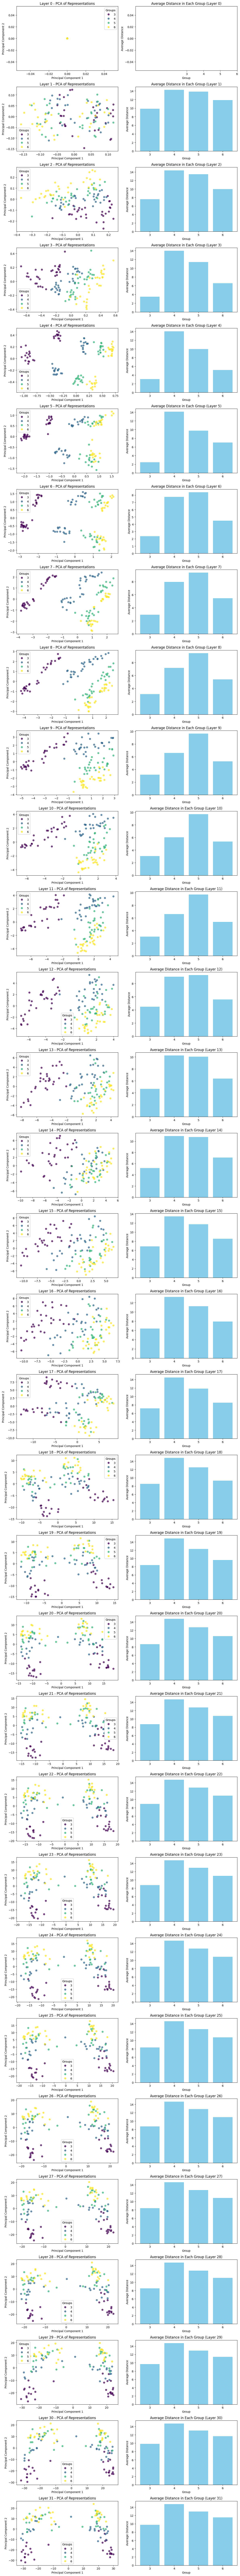

In [5]:
import matplotlib.pyplot as plt
import torch

# Parameters
layers = list(range(0, 32, 1))
fig, axs = plt.subplots(len(layers), 2, figsize=(12, len(layers) * 4))
groups_to_include = 'all'
use_pca = True
number_PCAs = 3
# Iterate through each layer
for idx, layer in enumerate(layers):
    hidden_states = {}
    
    # Collect hidden states for each prompt in each group
    for key, prompt_list in prompts.items():
        hidden_states[key] = []
        for prompt in prompt_list:
            hidden_state = model.get_hidden_state(prompt, layer_index=layer)
            hidden_states[key].append(hidden_state)
    
    all_representations = []
    all_labels = []
    
    if groups_to_include == 'all':
    # Collect representations from all groups for PCA 
        for group, reps in hidden_states.items():
            for rep in reps:
                all_representations.append(rep)
                all_labels.append(group)  # Label each representation by its group for plotting
    else:
    # or from specific groups
        selected_reps = hidden_states.get(groups_to_include, [])
        all_representations = selected_reps
        all_labels = [groups_to_include] * len(selected_reps)

    all_representations = torch.stack(all_representations).squeeze(1)  # Shape: (num_samples, embedding_dim)
    
    if all_representations.dim() != 2:
        raise ValueError("Expected 2D tensor for all_representations, but got different shape.")
    
    mean_centered = all_representations - all_representations.mean(dim=0, keepdim=True)
    U, S, V = torch.svd(mean_centered)  # Perform SVD
    principal_components = torch.mm(mean_centered, V[:, :number_PCAs])  # Project onto the first number_PCAs components

    # Separate PCA representations back into groups for distance calculation
    pca_hidden_states = {}
    start = 0
    for group, reps in hidden_states.items():
        pca_hidden_states[group] = principal_components[start:start + len(reps)]
        start += len(reps)

    if use_pca:
        distances = compute_avg_distances(pca_hidden_states, metric='cosine')
    else:
        distances = compute_avg_distances(hidden_states, metric='cosine')

    principal_components = torch.mm(mean_centered, V[:, :2])  # Project onto the first 2 components
    ax_pca = axs[idx, 0]
    scatter = ax_pca.scatter(principal_components[:, 0].cpu().numpy(), 
                             principal_components[:, 1].cpu().numpy(), 
                             c=all_labels, cmap='viridis', alpha=0.7)
    
    ax_pca.set_title(f'Layer {layer} - PCA of Representations')
    ax_pca.set_xlabel('Principal Component 1')
    ax_pca.set_ylabel('Principal Component 2')
    
    if groups_to_include == 'all':
        legend = ax_pca.legend(*scatter.legend_elements(), title="Groups")
        ax_pca.add_artist(legend)

    ax_dist = axs[idx, 1]
    ax_dist.bar(distances.keys(), distances.values(), color='skyblue')
    ax_dist.set_title(f'Average Distance in Each Group (Layer {layer})')
    ax_dist.set_xlabel('Group')
    ax_dist.set_ylabel('Average Distance')
    ax_dist.set_xticks(list(distances.keys()))

plt.tight_layout()
plt.show()


In [6]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


data = None # NumberOfstate x nd
# data_np = data.numpy()

# Step 2: Center the data manually
data_centered = data - np.mean(data, axis=0)

# Step 3: Apply PCA using sklearn
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_centered)

# Step 4: Print PCA results
print("PCA Components (Eigenvectors):\n", pca.components_)
print("Explained Variance (Eigenvalues):", pca.explained_variance_)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Step 5: Visualize the results
plt.figure(figsize=(12, 6))

# # Original centered data
# plt.subplot(1, 2, 1)
# plt.scatter(data_centered[:, 0], data_centered[:, 1], alpha=0.7, label="Original Data")
# plt.title("Original Centered Data")
# plt.xlabel("Feature 1")
# plt.ylabel("Feature 2")
# plt.axhline(0, color='gray', linewidth=0.5)
# plt.axvline(0, color='gray', linewidth=0.5)
# plt.legend()

# PCA-transformed data
plt.subplot(1, 2, 2)
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.7, label="PCA Data")
plt.title("Data after PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()


AxisError: axis 0 is out of bounds for array of dimension 0